<h1>Modelos Boosting</h1>

<h2>1.Librerías</h2>

In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, HistGradientBoostingRegressor

import matplotlib.pyplot as plt

import optuna

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<h2>2. Dataset y características</h2>

In [4]:
df = pd.read_csv('dataset_priv (7).csv')

In [5]:
df.head()

,codPaq,mes_alta,diasem_alta,turno,num_envios,alto,ancho,largo,peso,pv,cp,unidad,tipo,ur,ud,use,ot,osp,distancia,tiempo_entrega,x_dest,y_dest,min_reparto,dist_reparto
0,PQ4A760720292310141089P,12,1,0,5,7,28,35,350,1.143333,41089,4119194,UD,0,1,0,0,0,0.235,25.4,-5.928283,37.338425,532,0.260
1,PQ7X3V0710164690141010P,3,5,0,9,2,15,21,53,0.105000,41010,4108296,UR,1,0,0,0,0,1.365,292.2,-6.006863,37.388579,514,2.508
2,PQ4AHX0710436530141920X,10,1,0,8,16,27,20,960,1.440000,41920,4118994,UD,0,1,0,0,0,0.152,58.8,-6.035740,37.359857,535,0.623
3,PQ9RY80710004270141704D,10,5,1,6,30,15,5,323,0.375000,41704,4118094,UD,0,1,0,0,0,1.923,94.8,-5.935621,37.304995,908,1.923
4,PQ936A0785175420141960C,12,1,0,4,0,0,0,340,0.000000,41960,4196001,OT,0,0,0,1,0,0.670,11.7,-6.078531,37.389072,743,0.670


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461476 entries, 0 to 461475
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   codPaq          461476 non-null  object 
 1   mes_alta        461476 non-null  int64  
 2   diasem_alta     461476 non-null  int64  
 3   turno           461476 non-null  int64  
 4   num_envios      461476 non-null  int64  
 5   alto            461476 non-null  int64  
 6   ancho           461476 non-null  int64  
 7   largo           461476 non-null  int64  
 8   peso            461476 non-null  int64  
 9   pv              461476 non-null  float64
 10  cp              461476 non-null  int64  
 11  unidad          461476 non-null  int64  
 12  tipo            461476 non-null  object 
 13  ur              461476 non-null  int64  
 14  ud              461476 non-null  int64  
 15  use             461476 non-null  int64  
 16  ot              461476 non-null  int64  
 17  osp       

In [7]:
df.columns

Index(['codPaq', 'mes_alta', 'diasem_alta', 'turno', 'num_envios', 'alto', 'ancho', 'largo', 'peso', 'pv', 'cp', 'unidad', 'tipo', 'ur', 'ud', 'use', 'ot', 'osp', 'distancia', 'tiempo_entrega', 'x_dest', 'y_dest', 'min_reparto', 'dist_reparto'], dtype='object')

<h2>3. Dataset Final</h2>

In [8]:
# Eliminamos:
## codPaq: porque es el código único del dataset 
## 'alto','largo','ancho': porque está incluído en el peso volumétrico.
## tipo porque está representado en one-hot encoder.
df_1 = df.drop(['codPaq','alto','largo','ancho', 'tipo','turno'],axis=1)

<h2>4. Preprocesamiento</h2>
<h3>4.1 Matriz de correlación</h3>

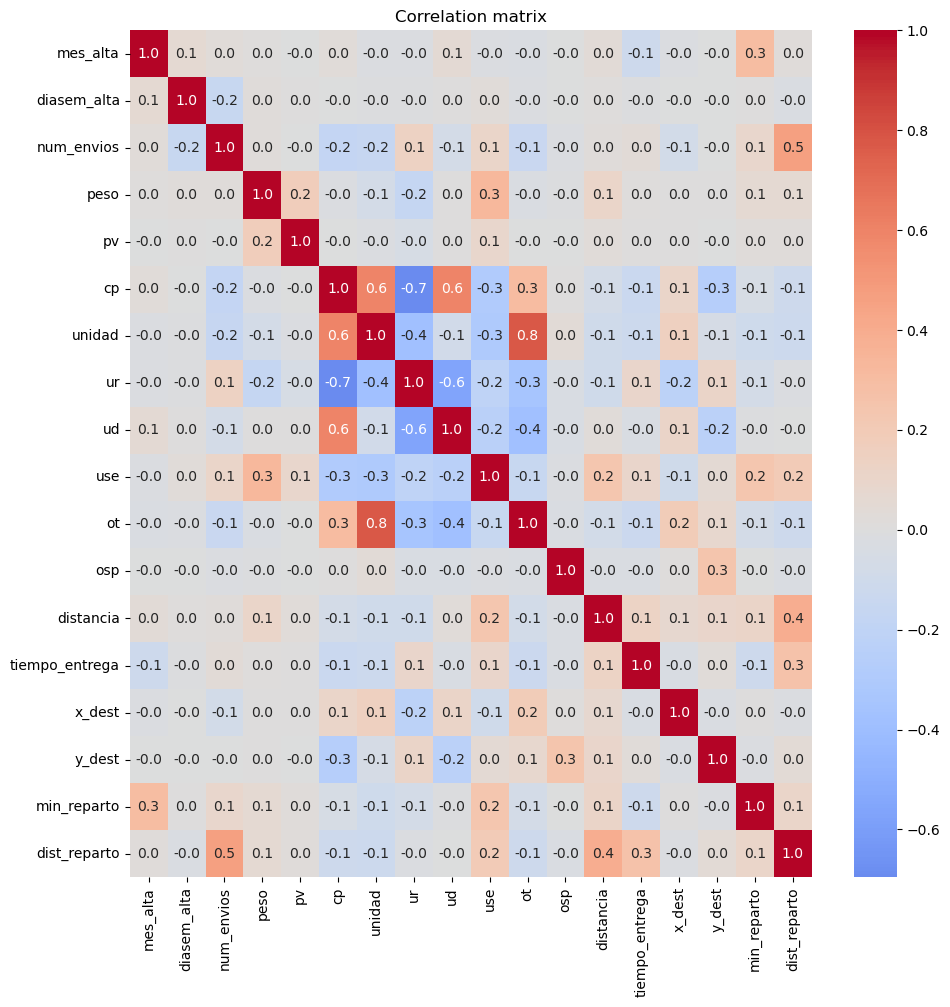

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns
corr_features = list(df_1.columns)
cc = np.corrcoef(df_1[corr_features], rowvar=False)
plt.figure(figsize=(11, 11))
sns.heatmap(cc, center=0, cmap='coolwarm', annot=True, fmt='.1f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()


<h3>4.2. Histogramas del dataset final</h3>

In [41]:
bins_dict = {
    'mes_alta':12,
    'diasem_alta': 6,
    'min_reparto':30,
    'turno': 2,
    'num_envios': 30,
    'peso': 100,
    'pv':100,
    'unidad':100,
    'ur':2,
    'ud':2,
    'use':2,
    'ot':2,
    'osp': 5,
    'distancia':30,
    'tiempo_entrega':100,
    'x_dest':1000,
    'y_dest':1000,
    'dist_reparto':1000
}

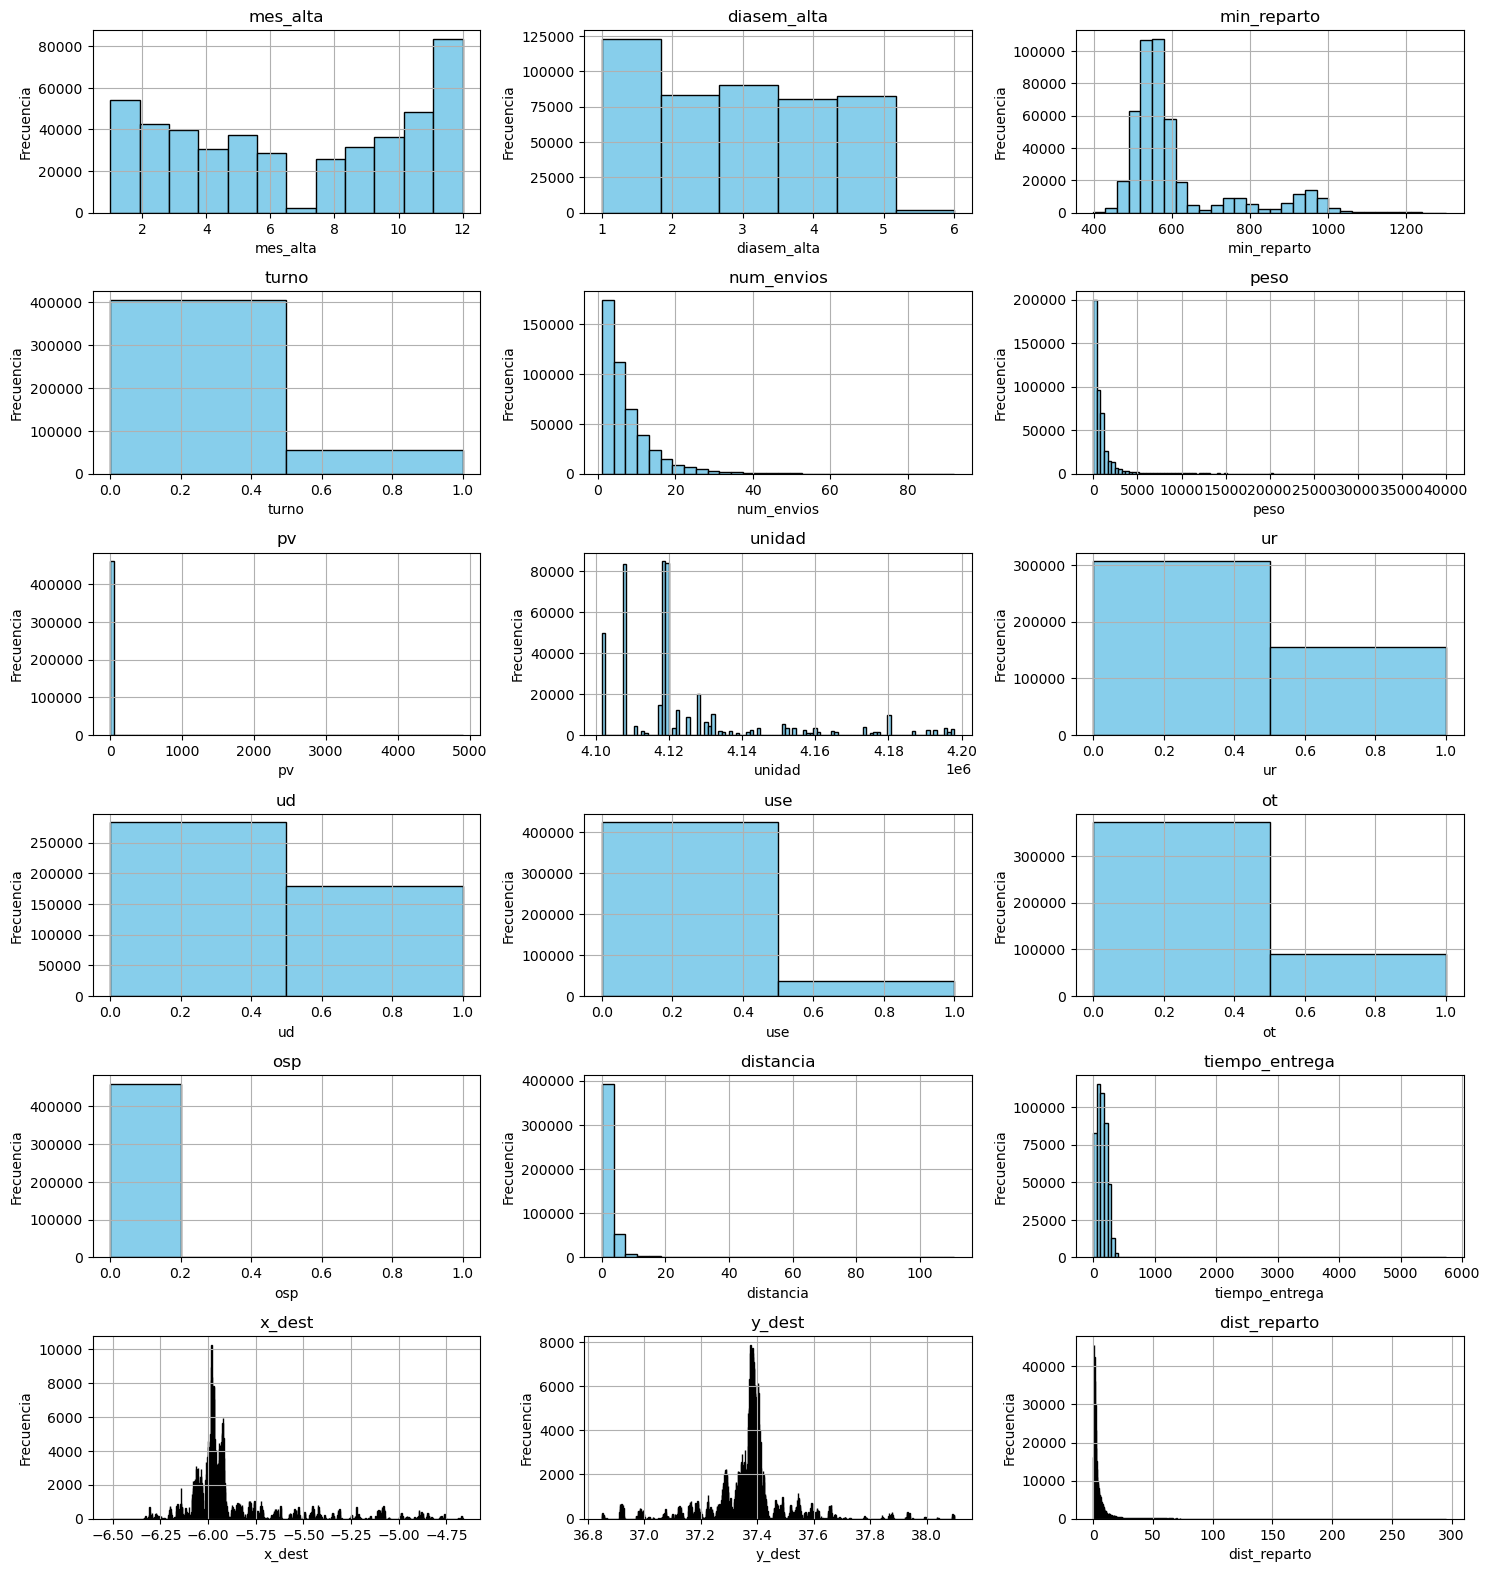

In [42]:
fig, axes = plt.subplots(len(bins_dict)//3 + 1, 3, figsize=(15, 18))
axes = axes.flatten()

for ax, (column, bins) in zip(axes, bins_dict.items()):
    df_1[column].hist(ax=ax, bins=bins, color='skyblue', edgecolor='black')
    ax.set_title(f'{column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')

# Eliminar ejes vacíos
for ax in axes[len(bins_dict):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

<h2>5.Entrenamiento de los modelos</h2>

In [10]:
X = df_1.drop(columns=['tiempo_entrega']).copy()
y = df_1['tiempo_entrega'].copy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1, shuffle=True)

In [12]:
X_train.columns

Index(['mes_alta', 'diasem_alta', 'num_envios', 'peso', 'pv', 'cp', 'unidad', 'ur', 'ud', 'use', 'ot', 'osp', 'distancia', 'x_dest', 'y_dest', 'min_reparto', 'dist_reparto'], dtype='object')

In [13]:
#cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'bool']
num_cols = [col for col in X_train.columns if X_train[col].dtype == 'float64' or X_train[col].dtype == 'int64']

In [14]:
preprocessing = make_column_transformer(
    (StandardScaler(),num_cols)
)

X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)

<h2>6. Hiperparámetros Optuna</h2>

<h3>6.1. AdaBoost Regressor</h3>

In [16]:

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)
    random_state = trial.suggest_int('random_state', 1, 2030)
    
    model = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2024-06-18 10:33:29,601] A new study created in memory with name: no-name-649f88e1-0c74-4ff0-bd3e-e6e799446166
[I 2024-06-18 10:34:20,369] Trial 0 finished with value: 61.02424940060276 and parameters: {'n_estimators': 555, 'learning_rate': 0.303452784328793, 'random_state': 209}. Best is trial 0 with value: 61.02424940060276.
[I 2024-06-18 10:43:14,986] Trial 1 finished with value: 57.19041525877706 and parameters: {'n_estimators': 347, 'learning_rate': 0.0013734569427470975, 'random_state': 92}. Best is trial 1 with value: 57.19041525877706.
[I 2024-06-18 10:43:46,262] Trial 2 finished with value: 59.51509548944185 and parameters: {'n_estimators': 287, 'learning_rate': 0.504537656911408, 'random_state': 1904}. Best is trial 1 with value: 57.19041525877706.
[I 2024-06-18 10:44:19,298] Trial 3 finished with value: 59.70373817644177 and parameters: {'n_estimators': 960, 'learning_rate': 0.59847463572895, 'random_state': 1388}. Best is trial 1 with value: 57.19041525877706.
[I 2024-06

<h3>6.2. CatBoost Regressor</h3>

In [16]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'MAE',
        'random_seed': trial.suggest_int('random_state', 1, 2030)
    }
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_mae = study.best_value

print("Mejores hiperparámetros encontrados:", best_params)
print("MAE asociado a los mejores hiperparámetros:", best_mae)

[I 2024-06-19 09:42:09,052] A new study created in memory with name: no-name-01507e6a-69ad-4ec6-93ef-961ec838e38d
[I 2024-06-19 09:42:58,434] Trial 0 finished with value: 47.20138334942025 and parameters: {'iterations': 891, 'learning_rate': 0.015136159873138863, 'depth': 5, 'l2_leaf_reg': 0.21590582791073734, 'border_count': 35, 'random_state': 1410}. Best is trial 0 with value: 47.20138334942025.
[I 2024-06-19 09:43:02,775] Trial 1 finished with value: 62.59996620219577 and parameters: {'iterations': 67, 'learning_rate': 0.0026127159899199696, 'depth': 6, 'l2_leaf_reg': 8.307711152815246, 'border_count': 112, 'random_state': 66}. Best is trial 0 with value: 47.20138334942025.
[I 2024-06-19 09:43:51,798] Trial 2 finished with value: 51.808530334311946 and parameters: {'iterations': 896, 'learning_rate': 0.0027718929955304616, 'depth': 5, 'l2_leaf_reg': 1.0693870169194775, 'border_count': 134, 'random_state': 1915}. Best is trial 0 with value: 47.20138334942025.
[I 2024-06-19 09:44:03,

Mejores hiperparámetros encontrados: {'iterations': 949, 'learning_rate': 0.09928296098742184, 'depth': 10, 'l2_leaf_reg': 5.588067842399302, 'border_count': 159, 'random_state': 1692}
MAE asociado a los mejores hiperparámetros: 39.28013727741641


<h3>6.3. XGBoost</h3>

In [17]:
import xgboost as xgb
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae', 
        'booster': 'gbtree',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 0.1, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 0.1, 10.0, log=True),
        'random_state': trial.suggest_int('random_state', 1, 2030)
    }
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'eval')],
                      early_stopping_rounds=10, verbose_eval=False)

    y_pred = model.predict(dtest)
    return mean_absolute_error(y_test, y_pred) 

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_mae = study.best_value

print("Mejores hiperparámetros encontrados:", best_params)
print("MAE asociado a los mejores hiperparámetros:", best_mae)


[I 2024-06-19 12:57:27,648] A new study created in memory with name: no-name-559b1bfc-c730-4990-9669-3c9c20c10d96
[I 2024-06-19 12:57:31,906] Trial 0 finished with value: 45.9483998288217 and parameters: {'learning_rate': 0.09899349459532342, 'max_depth': 5, 'subsample': 0.7068328431233805, 'colsample_bytree': 0.9405901377724355, 'lambda': 2.039282087270943, 'alpha': 0.7152852600259464, 'random_state': 1137}. Best is trial 0 with value: 45.9483998288217.
[I 2024-06-19 12:57:38,952] Trial 1 finished with value: 60.37403288661091 and parameters: {'learning_rate': 0.0024579653600455935, 'max_depth': 9, 'subsample': 0.5374620715296657, 'colsample_bytree': 0.9941034822774323, 'lambda': 6.1876621025069625, 'alpha': 0.17708880854977133, 'random_state': 239}. Best is trial 0 with value: 45.9483998288217.
[I 2024-06-19 12:57:42,642] Trial 2 finished with value: 59.08676753417863 and parameters: {'learning_rate': 0.009879419308894195, 'max_depth': 3, 'subsample': 0.6324856870478568, 'colsample_b

Mejores hiperparámetros encontrados: {'learning_rate': 0.09241113783791961, 'max_depth': 10, 'subsample': 0.8103326689056188, 'colsample_bytree': 0.7137450259157744, 'lambda': 0.12059032836105718, 'alpha': 0.11114926337199811, 'random_state': 968}
MAE asociado a los mejores hiperparámetros: 39.98440603010033


<h3>6.4.Histogram Gradient Boosting Regressor</h3>

In [15]:
from sklearn.metrics import mean_absolute_error

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 1000),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10, 1e3, log=True),
        'random_state': trial.suggest_int('random_state', 1, 2030)
    }
    model = HistGradientBoostingRegressor(**params, loss='absolute_error')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_mae = study.best_value

print("Mejores hiperparámetros encontrados:")
print(best_params)
print("Mejor MAE encontrado:")
print(best_mae)


[I 2024-06-20 09:25:23,734] A new study created in memory with name: no-name-7529910f-66c3-4855-8854-5a3d60153ee5
[I 2024-06-20 09:25:36,370] Trial 0 finished with value: 40.87522566530762 and parameters: {'learning_rate': 0.22055923782102063, 'max_depth': 13, 'min_samples_leaf': 12, 'max_leaf_nodes': 106, 'l2_regularization': 1.901280609064678e-07, 'random_state': 863}. Best is trial 0 with value: 40.87522566530762.
[I 2024-06-20 09:26:28,435] Trial 1 finished with value: 39.560889336948826 and parameters: {'learning_rate': 0.06749461434193443, 'max_depth': 12, 'min_samples_leaf': 17, 'max_leaf_nodes': 749, 'l2_regularization': 6.505525501276283e-10, 'random_state': 908}. Best is trial 1 with value: 39.560889336948826.
[I 2024-06-20 09:27:38,558] Trial 2 finished with value: 41.478355907194675 and parameters: {'learning_rate': 0.025612987826083487, 'max_depth': 14, 'min_samples_leaf': 11, 'max_leaf_nodes': 946, 'l2_regularization': 1.4833233560029202e-05, 'random_state': 1713}. Best i

Mejores hiperparámetros encontrados:
{'learning_rate': 0.24518538196114872, 'max_depth': 15, 'min_samples_leaf': 16, 'max_leaf_nodes': 973, 'l2_regularization': 2.5940023278257853e-09, 'random_state': 1102}
Mejor MAE encontrado:
37.37353731647347


<h3>6.5.Gradient Boosting Regressor </h3>

In [16]:
def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, log=True),
        'random_state': trial.suggest_int('random_state', 1, 2030) 
    }

    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best trial:')
print(study.best_trial.params)
print('Best MAE:', study.best_trial.value)

[I 2024-06-22 13:16:50,008] A new study created in memory with name: no-name-4a204aed-fb70-41a3-86e6-318a9c51c89d
[I 2024-06-22 13:20:26,575] Trial 0 finished with value: 54.317537284786276 and parameters: {'n_estimators': 99, 'learning_rate': 0.006499611502852991, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 7, 'subsample': 0.5396999746509491, 'random_state': 498}. Best is trial 0 with value: 54.317537284786276.
[I 2024-06-22 13:34:39,842] Trial 1 finished with value: 44.019504522169306 and parameters: {'n_estimators': 477, 'learning_rate': 0.05265180732077026, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.9003371769538417, 'random_state': 1275}. Best is trial 1 with value: 44.019504522169306.
[I 2024-06-22 13:39:15,678] Trial 2 finished with value: 48.09200066925364 and parameters: {'n_estimators': 256, 'learning_rate': 0.02933720859789541, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 3, 'subsample': 0.6120653458452588, 

Best trial:
{'n_estimators': 385, 'learning_rate': 0.09970322096454429, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.9747390847894842, 'random_state': 2030}
Best MAE: 37.44880149851854


<h3>6.6. Resumen hiperparámetros usados</h3>

In [24]:
import pandas as pd

boosting_algorithms = ['AdaBoost', 'Gradient Boosting', 'Histogram-based Gradient Boosting', 'CatBoost', 'XGBoost']

hyperparameters = {
    'AdaBoost': ['n_estimators', 'learning_rate','random_state','','','',''],
    'Gradient Boosting': ['n_estimators', 'learning_rate', 'max_depth', 'min_samples_split', 'min_samples_leaf','subsample','random_state'],
    'Histogram-based Gradient Boosting': ['learning_rate', 'max_depth', 'min_samples_leaf','max_leaf_nodes','l2_regularization','random_state',''],
    'CatBoost': ['iterations', 'learning_rate', 'depth', 'l2_leaf_reg', 'border_count','random_seed',''],
    'XGBoost': ['learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 'lambda', 'alpha','random_state']
} 

df = pd.DataFrame(columns=boosting_algorithms)
for algorithm, params in hyperparameters.items():
    df[algorithm] = params
df


,AdaBoost,Gradient Boosting,Histogram-based Gradient Boosting,CatBoost,XGBoost
0,n_estimators,n_estimators,learning_rate,iterations,learning_rate
1,learning_rate,learning_rate,max_depth,learning_rate,max_depth
2,random_state,max_depth,min_samples_leaf,depth,subsample
3,,min_samples_split,max_leaf_nodes,l2_leaf_reg,colsample_bytree
4,,min_samples_leaf,l2_regularization,border_count,lambda
5,,subsample,random_state,random_seed,alpha
6,,random_state,,,random_state


In [15]:
'''Nuevos hiperparametros'''
params_GBR ={'n_estimators': 385, 'learning_rate': 0.09970322096454429, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 
 'subsample': 0.9747390847894842, 'random_state': 2030}
params_hGB = {'learning_rate': 0.24518538196114872, 'max_depth': 15, 'min_samples_leaf': 16, 'max_leaf_nodes': 973, 
 'l2_regularization': 2.5940023278257853e-09, 'random_state': 1102}
params_xgboost = {'learning_rate': 0.09241113783791961, 'max_depth': 10, 'subsample': 0.8103326689056188, 'colsample_bytree': 0.7137450259157744, 
 'lambda': 0.12059032836105718, 'alpha': 0.11114926337199811, 'random_state': 968}
params_catboost = {'iterations': 949, 'learning_rate': 0.09928296098742184, 'depth': 10, 'l2_leaf_reg': 5.588067842399302, 'border_count': 159, 'random_state': 1692}
params_ada = {'n_estimators': 67, 'learning_rate': 0.0010205881159072521, 'random_state': 28}

<h2>7. Resultados</h2>

In [16]:

results = {'Model': [], 'RMSE': [], 'MAE': [], 'R2': []}
rmse_results = {}
mae_results = {}
predictions = {'y_test': y_test}  # Diccionario para almacenar las predicciones

# Lista de modelos
models = [
    ('AdaBoost', AdaBoostRegressor(**params_ada)),
    ('HistGradientBoosting', HistGradientBoostingRegressor(**params_hGB)),
    ('GBM', GradientBoostingRegressor(**params_GBR)),
    ('CATB', CatBoostRegressor(**params_catboost, verbose=0)),
    ('XGB', XGBRegressor(**params_xgboost, verbosity=0)),
]

for name, model in models:
    print(f"Entrenando y evaluando {name}...")
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    #mse = mean_squared_error(y_test, y_pred)
    rmse_results[name] = (train_rmse, test_rmse)
    mae_results[name] = (train_mae, test_mae)
    results['Model'].append(name)
    results['RMSE'].append(test_rmse)
    results['MAE'].append(test_mae)
    results['R2'].append(r2)

    # Añadir las predicciones al diccionario con prefijo para diferenciarlas
    predictions[f'{name}_pred'] = y_pred
    print(f"{name} - RMSE de Entrenamiento: {train_rmse}, RMSE de Prueba: {test_rmse}")
    print(f"{name} - MAE de Entrenamiento: {train_mae}, MAE de Prueba: {test_mae}")
    print(' '*30)
# Convertir el diccionario de resultados en un DataFrame
results_df = pd.DataFrame(results)

# Convertir el diccionario de predicciones en un DataFrame
predictions_df = pd.DataFrame(predictions)

# Mostrar los DataFrames
print(results_df)
print(predictions_df)

Entrenando y evaluando AdaBoost...
AdaBoost - RMSE de Entrenamiento: 74.4809456275301, RMSE de Prueba: 73.28505565263457
AdaBoost - MAE de Entrenamiento: 57.12279474318569, MAE de Prueba: 57.12750448063801
                              
Entrenando y evaluando HistGradientBoosting...
HistGradientBoosting - RMSE de Entrenamiento: 36.37215448818173, RMSE de Prueba: 53.82984861555638
HistGradientBoosting - MAE de Entrenamiento: 26.164004022161656, MAE de Prueba: 37.16555189342237
                              
Entrenando y evaluando GBM...
GBM - RMSE de Entrenamiento: 39.09082938994565, RMSE de Prueba: 53.700105305268366
GBM - MAE de Entrenamiento: 29.42583731425605, MAE de Prueba: 37.33190766635032
                              
Entrenando y evaluando CATB...
CATB - RMSE de Entrenamiento: 48.584136771914935, RMSE de Prueba: 55.9015966742898
CATB - MAE de Entrenamiento: 36.916879306604535, MAE de Prueba: 39.77655589466586
                              
Entrenando y evaluando XGB...
XGB - R

<h2>8. Visualización de resultados</h2>

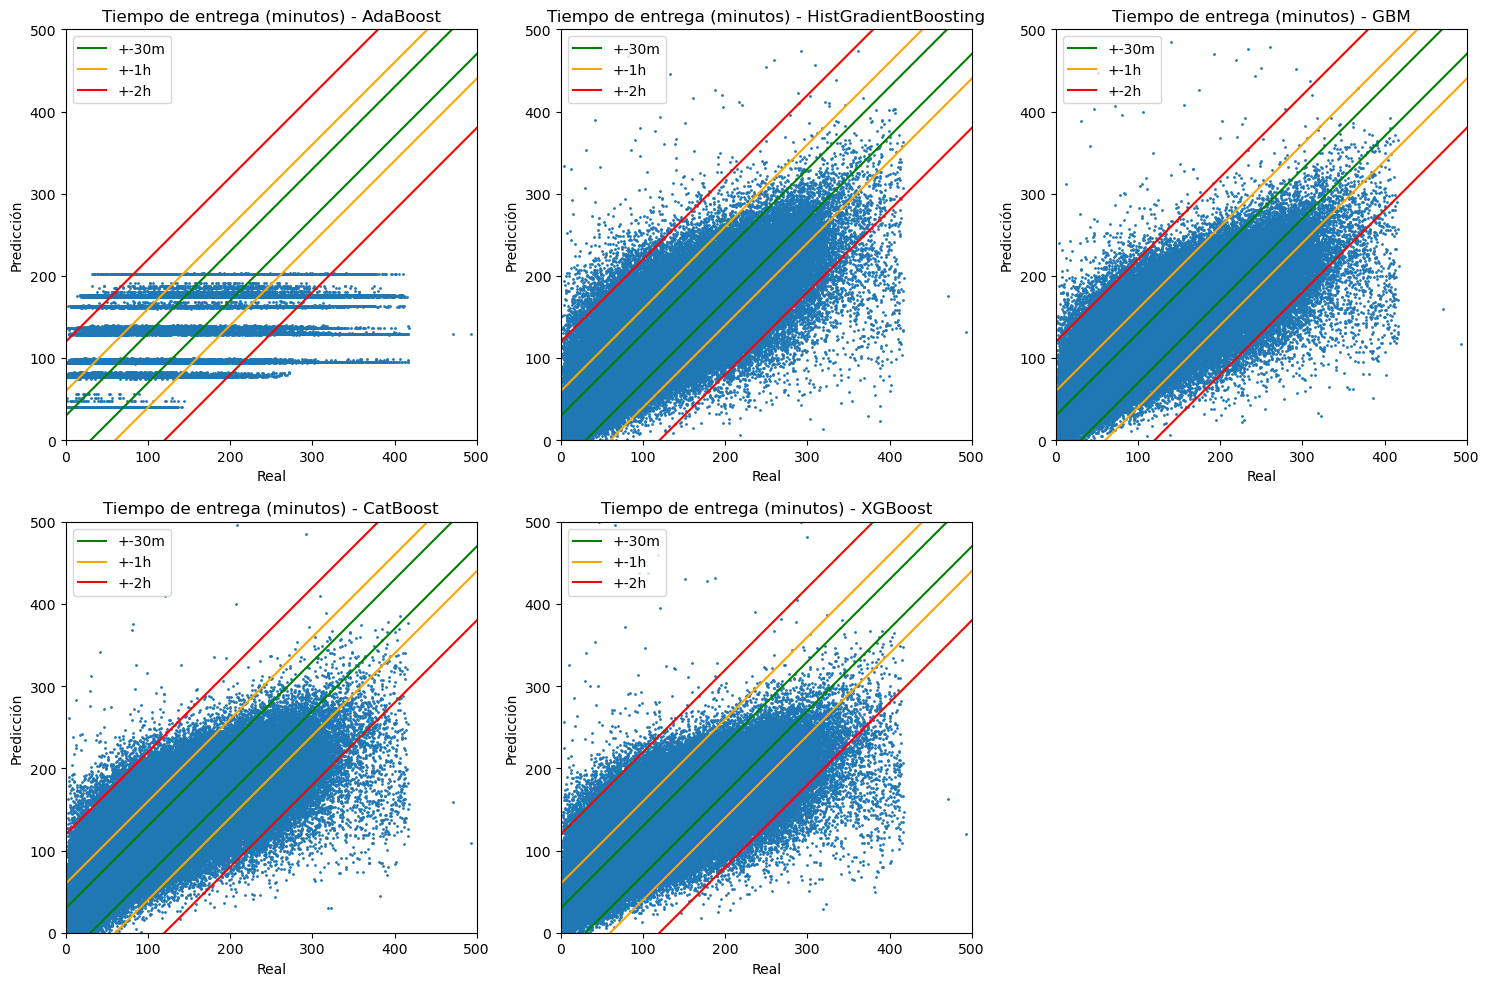

In [27]:
# Función para mostrar la gráfica de predicciones frente al valor real
def plot_predictions(y_test, y_pred, model_name, ax):
    max_range = 120
    mid_range = 60
    min_range = 30
    max_value = 500  # Limitar a 500

    # Gráfico principal
    ax.scatter(y_test, y_pred, s=1)
    ax.set_title("Tiempo de entrega (minutos) - " + model_name)
    ax.set_xlabel('Real')
    ax.set_ylabel('Predicción')
    ax.axis('equal')
    ax.axis('square')
    ax.set_xlim([0, max_value])
    ax.set_ylim([0, max_value])
    ax.plot([0, max_value], [min_range, max_value + min_range], color='green', label='+-30m')
    ax.plot([min_range, max_value + min_range], [0, max_value], color='green')
    ax.plot([0, max_value], [mid_range, max_value + mid_range], color='orange', label='+-1h')
    ax.plot([mid_range, max_value + mid_range], [0, max_value], color='orange')
    ax.plot([0, max_value], [max_range, max_value + max_range], color='red', label='+-2h')
    ax.plot([max_range, max_value + max_range], [0, max_value], color='red')
    ax.legend(loc='upper left')  # Especificar la ubicación de la leyenda

# Crear subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Ajustar las predicciones en los subplots
plot_predictions(predictions_df['y_test'], predictions_df['AdaBoost_pred'], 'AdaBoost', axs[0, 0])
plot_predictions(predictions_df['y_test'], predictions_df['HistGradientBoosting_pred'], 'HistGradientBoosting', axs[0, 1])
plot_predictions(predictions_df['y_test'], predictions_df['GBM_pred'], 'GBM', axs[0, 2])
#plot_predictions(predictions_df['y_test'], predictions_df['GBM_pred'], 'GBM', axs[1, 0])
plot_predictions(predictions_df['y_test'], predictions_df['CATB_pred'], 'CatBoost', axs[1, 0])
plot_predictions(predictions_df['y_test'], predictions_df['XGB_pred'], 'XGBoost', axs[1, 1])

# Eliminar el subplot vacío en (1, 2)
fig.delaxes(axs[1, 2])

# Ajustar el espaciado
plt.tight_layout()

# Mostrar las gráficas
plt.show()


In [21]:
# Define the accuracy function
def accuracy(error):
    print("Precisión:")
    #print("+-15m: " + str(round((error.loc[(error > -15) & (error < 15)].count() / error.count()) * 100, 1)) + "%")
    print("+-30m: " + str(round((error.loc[(error > -30) & (error < 30)].count() / error.count()) * 100, 1)) + "%")
    print("+-1h : " + str(round((error.loc[(error > -60) & (error < 60)].count() / error.count()) * 100, 1)) + "%")
    print("+-2h : " + str(round((error.loc[(error > -120) & (error < 120)].count() / error.count()) * 100, 1)) + "%")

# Calculate errors
predictions_df['AdaBoost'] = predictions_df['AdaBoost_pred'] - predictions_df['y_test']
predictions_df['HGB'] = predictions_df['HistGradientBoosting_pred'] - predictions_df['y_test']
predictions_df['GBM'] = predictions_df['GBM_pred'] - predictions_df['y_test']
predictions_df['CatBoost'] = predictions_df['CATB_pred'] - predictions_df['y_test']
predictions_df['XGBoost'] = predictions_df['XGB_pred'] - predictions_df['y_test']

# List of error columns
error_columns = ['AdaBoost', 'HGB', 'GBM', 'CatBoost', 'XGBoost']

# Loop through the errors and print accuracy
for error_col in error_columns:
    print(error_col + ':')
    accuracy(predictions_df[error_col])
    print()  # Add a new line for better readability

AdaBoost:
Precisión:
+-30m: 30.1%
+-1h : 58.1%
+-2h : 93.1%

HGB:
Precisión:
+-30m: 52.3%
+-1h : 80.4%
+-2h : 97.6%

GBM:
Precisión:
+-30m: 51.0%
+-1h : 80.0%
+-2h : 97.8%

CatBoost:
Precisión:
+-30m: 47.8%
+-1h : 77.6%
+-2h : 97.6%

XGBoost:
Precisión:
+-30m: 47.4%
+-1h : 77.2%
+-2h : 97.5%

